# Install

In [1]:
!pip install opencv-python
!pip install pytesseract
!pip install Pillow
!pip install matplotlib pandas

# Import libraries

In [2]:
import cv2
import os
import re
import numpy as np
import pytesseract
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pytesseract import Output
from PIL import Image, ImageOps,  ImageDraw
import colorsys
from datetime import datetime, timedelta
from IPython.display import clear_output, display
from matplotlib.colors import rgb_to_hsv
from scipy.spatial.distance import euclidean
from skimage.measure import label, regionprops
import matplotlib.colors as colors
import matplotlib.dates as mdates

# Resize the images

In [3]:
# Define the path to the directory containing the images
image_directory = 'Thermal Placement 3'
output_directory = os.path.join(image_directory, 'resized')
os.makedirs(output_directory, exist_ok=True)  # Ensure the output directory exists

# Define resizing function
def resize_image(image_path, output_size=(320, 240)):
    """Resize the given image to the specified dimensions."""
    with Image.open(image_path) as img:
        resized_img = img.resize(output_size, Image.Resampling.LANCZOS)
        return resized_img

# Example static date for renaming
static_date = '20240314'

# Counter for resized images
count_resized = 0  

# Process, resize, and rename images
for file_name in os.listdir(image_directory):
    file_path = os.path.join(image_directory, file_name)
    if file_name.startswith('thermal_') and file_name.endswith('.jpg') and os.path.isfile(file_path):
        # Resize the image
        resized_image = resize_image(file_path)
        
        # Generate new filename without repeating the extension
        time_part = file_name.split('_')[1].replace('-', '')
        new_filename = f"photo_{static_date}-{time_part}"  # Use .jpg only once
        new_path = os.path.join(output_directory, new_filename)
        
        # Save the resized image with the new name
        resized_image.save(new_path)
        count_resized += 1

print(f"Total images resized and renamed: {count_resized}")

Total images resized and renamed: 129


# Define ROI for OCR (Left side)

In [4]:
# Update the directory and file list after resizing and renaming
image_directory = 'Thermal Placement 3/resized'
image_files = os.listdir(image_directory)

# Define your ROI coordinates (x, y, w, h)
roi_hottest = (4, 178, 36, 19)
roi_coldest = (4, 45, 38, 19)

# Apply interpolation & replace invalid value
We decided to use this as hottest temperature got better RMSE (Compare to the accurate one), even though coldest temperature'sRMSE is slightly higher than median function.  

**Int** 	  
MAE_Cold:	0.4705  
MAPE_Cold:	0.0229  
RMSE_Cold:	0.7965  
	
**Avg**	 
MAE_Cold:	0.4639   
MAPE_Cold:	0.0276  
RMSE_Cold:	0.7901  
	
**Int**   
MAE_Hot:	0.1946  
MAPE_Hot:	0.0071  
RMSE_Hot:	0.6068  
	
**Avg**	  
MAE_Hot:	0.8584  
MAPE_Hot:	0.0336  
RMSE_Hot:	1.8496   

In [5]:
def is_interval_close_to_10_minutes(time1, time2):
    """Check if the interval between two times is approximately 10 minutes."""
    interval = abs(time2 - time1)
    return timedelta(minutes=1, seconds=30) < interval < timedelta(minutes=10, seconds=30)

def clean_temperature(ocr_result, max_value=35.0):
    """Clean the OCR result to extract temperature, ensuring it does not exceed the max_value if specified."""
    cleaned_text = re.sub(r'[^\d.]+', '', ocr_result)
    if not cleaned_text or not re.match(r'^\d{1,2}\.\d$', cleaned_text):
        return 'Invalid'
    temp_value = float(cleaned_text)
    if 13.0 <= temp_value <= max_value:
        return cleaned_text
    else:
        return 'Invalid'

def interpolate_temperatures(temps):
    """Interpolate 'Invalid' temperatures in a list of temperatures."""
    if not temps or all(temp == 'Invalid' for temp in temps):
        return temps  # Return as is if empty or all invalid
    
    # Convert all valid temperature strings to floats, keep 'Invalid' as is
    for i in range(len(temps)):
        if temps[i] != 'Invalid':
            temps[i] = float(temps[i])

    # Interpolate invalid values
    for i in range(len(temps)):
        if temps[i] == 'Invalid':
            # Find the nearest previous valid temperature
            prev_temp = None
            for j in range(i - 1, -1, -1):
                if temps[j] != 'Invalid':
                    prev_temp = temps[j]
                    break
            
            # Find the nearest next valid temperature
            next_temp = None
            for j in range(i + 1, len(temps)):
                if temps[j] != 'Invalid':
                    next_temp = temps[j]
                    break

            # Calculate the interpolated temperature
            if prev_temp is not None and next_temp is not None:
                temps[i] = (prev_temp + next_temp) / 2
            elif prev_temp is not None:
                temps[i] = prev_temp  # Use the previous temp if no next temp
            elif next_temp is not None:
                temps[i] = next_temp  # Use the next temp if no previous temp

    # Convert temperatures back to string format if necessary
    return [str(temp) if isinstance(temp, float) else temp for temp in temps]

all_results = []

# Process resized images
for image_name in image_files:
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
        base_name = os.path.splitext(image_name)[0]
        timestamp_str = base_name.split('_')[1]
        frame_datetime = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')

        image_path = os.path.join(image_directory, image_name)
        image = Image.open(image_path)

        cropped_hottest = image.crop((roi_hottest[0], roi_hottest[1], roi_hottest[0] + roi_hottest[2], roi_hottest[1] + roi_hottest[3]))
        gray_hottest = ImageOps.grayscale(cropped_hottest)
        text_hottest = pytesseract.image_to_string(gray_hottest)
        
        cropped_coldest = image.crop((roi_coldest[0], roi_coldest[1], roi_coldest[0] + roi_coldest[2], roi_coldest[1] + roi_coldest[3]))
        gray_coldest = ImageOps.grayscale(cropped_coldest)
        text_coldest = pytesseract.image_to_string(gray_coldest)

        hottest_temp = clean_temperature(text_hottest)  # Use default max_value of 35.0
        coldest_temp = clean_temperature(text_coldest, max_value=22.0)  # Set max_value to 22.0 for coldest

        all_results.append((frame_datetime, hottest_temp, coldest_temp))
        
# Sort the results by datetime
sorted_results = sorted(all_results, key=lambda x: x[0])

# Apply filtering for ~10-minute intervals

filtered_results = []
for i in range(1, len(sorted_results)):
    if is_interval_close_to_10_minutes(sorted_results[i-1][0], sorted_results[i][0]):
        filtered_results.append(sorted_results[i-1])
if len(sorted_results) > 1 and is_interval_close_to_10_minutes(sorted_results[-2][0], sorted_results[-1][0]):
    filtered_results.append(sorted_results[-1])


# Separate temperatures and interpolate invalid values for filtered results
hottest_temps = [result[1] for result in filtered_results]
coldest_temps = [result[2] for result in filtered_results]
interpolated_hottest = interpolate_temperatures(hottest_temps)
interpolated_coldest = interpolate_temperatures(coldest_temps)

# Update filtered_results with interpolated temperatures
for i, _ in enumerate(filtered_results):
    filtered_results[i] = (filtered_results[i][0], interpolated_hottest[i], interpolated_coldest[i])

print(f"Total Results After Filtering and Interpolation: {len(filtered_results)}")
for result in filtered_results:
    frame_datetime = result[0].strftime('%Y-%m-%d %H:%M:%S')
    # Ensure temperatures are floats, then format to one decimal place
    hottest = float(result[1]) if result[1] != 'Invalid' else result[1]
    coldest = float(result[2]) if result[2] != 'Invalid' else result[2]
    
    hottest_str = f"{hottest:.1f}" if hottest != 'Invalid' else hottest
    coldest_str = f"{coldest:.1f}" if coldest != 'Invalid' else coldest
    
    print(f"{frame_datetime}: Hottest {hottest_str}, Coldest {coldest_str}")

Total Results After Filtering and Interpolation: 128
2024-03-14 00:07:35: Hottest 27.3, Coldest 19.9
2024-03-14 00:17:35: Hottest 27.3, Coldest 19.9
2024-03-14 00:27:35: Hottest 27.3, Coldest 19.9
2024-03-14 00:37:36: Hottest 28.2, Coldest 19.9
2024-03-14 00:47:36: Hottest 28.7, Coldest 20.6
2024-03-14 00:57:36: Hottest 29.0, Coldest 20.2
2024-03-14 01:07:37: Hottest 29.1, Coldest 20.2
2024-03-14 01:17:37: Hottest 29.1, Coldest 20.2
2024-03-14 01:27:38: Hottest 29.2, Coldest 20.2
2024-03-14 01:37:38: Hottest 29.2, Coldest 20.0
2024-03-14 01:47:38: Hottest 29.2, Coldest 20.1
2024-03-14 01:57:39: Hottest 29.2, Coldest 20.4
2024-03-14 02:07:39: Hottest 29.2, Coldest 20.3
2024-03-14 02:17:39: Hottest 29.2, Coldest 20.4
2024-03-14 02:27:40: Hottest 29.2, Coldest 20.0
2024-03-14 02:37:40: Hottest 29.4, Coldest 19.8
2024-03-14 02:47:40: Hottest 29.7, Coldest 19.7
2024-03-14 02:57:41: Hottest 29.8, Coldest 20.0
2024-03-14 03:07:41: Hottest 30.2, Coldest 19.8
2024-03-14 03:17:41: Hottest 27.3, 

# Check if any image is excluded

In [6]:
# Process the sorted results to filter based on ~10-minute intervals
included_results = []
excluded_results = []

for i in range(1, len(sorted_results)):
    if is_interval_close_to_10_minutes(sorted_results[i-1][0], sorted_results[i][0]):
        included_results.append(sorted_results[i-1])
    else:
        excluded_results.append(sorted_results[i-1])

# Ensure the last entry is checked
if len(sorted_results) > 1:
    if is_interval_close_to_10_minutes(sorted_results[-2][0], sorted_results[-1][0]):
        included_results.append(sorted_results[-1])
    else:
        excluded_results.append(sorted_results[-1])

# Display excluded results
print(f"Excluded Results: {len(excluded_results)}")
for result in excluded_results:
    frame_datetime = result[0].strftime('%Y-%m-%d %H:%M:%S')
    hottest = float(result[1]) if result[1] != 'Invalid' else result[1]
    coldest = float(result[2]) if result[2] != 'Invalid' else result[2]
    
    hottest_str = f"{hottest:.1f}" if hottest != 'Invalid' else hottest
    coldest_str = f"{coldest:.1f}" if coldest != 'Invalid' else coldest
    
    print(f"Excluded {frame_datetime}: Hottest {hottest_str}, Coldest {coldest_str}")

# Display included results
print(f"Included Results: {len(included_results)}")
for result in included_results:
    frame_datetime = result[0].strftime('%Y-%m-%d %H:%M:%S')
    hottest = float(result[1]) if result[1] != 'Invalid' else result[1]
    coldest = float(result[2]) if result[2] != 'Invalid' else result[2]
    
    hottest_str = f"{hottest:.1f}" if hottest != 'Invalid' else hottest
    coldest_str = f"{coldest:.1f}" if coldest != 'Invalid' else coldest
    
    print(f"Included {frame_datetime}: Hottest {hottest_str}, Coldest {coldest_str}")


Excluded Results: 1
Excluded 2024-03-14 11:58:00: Hottest Invalid, Coldest 19.4
Included Results: 128
Included 2024-03-14 00:07:35: Hottest Invalid, Coldest Invalid
Included 2024-03-14 00:17:35: Hottest Invalid, Coldest Invalid
Included 2024-03-14 00:27:35: Hottest 27.3, Coldest Invalid
Included 2024-03-14 00:37:36: Hottest Invalid, Coldest 19.9
Included 2024-03-14 00:47:36: Hottest Invalid, Coldest 20.6
Included 2024-03-14 00:57:36: Hottest Invalid, Coldest 20.2
Included 2024-03-14 01:07:37: Hottest Invalid, Coldest 20.2
Included 2024-03-14 01:17:37: Hottest Invalid, Coldest 20.2
Included 2024-03-14 01:27:38: Hottest Invalid, Coldest 20.2
Included 2024-03-14 01:37:38: Hottest Invalid, Coldest 20.0
Included 2024-03-14 01:47:38: Hottest Invalid, Coldest 20.1
Included 2024-03-14 01:57:39: Hottest Invalid, Coldest 20.4
Included 2024-03-14 02:07:39: Hottest Invalid, Coldest 20.3
Included 2024-03-14 02:17:39: Hottest Invalid, Coldest 20.4
Included 2024-03-14 02:27:40: Hottest 29.2, Coldest 

# Visualization

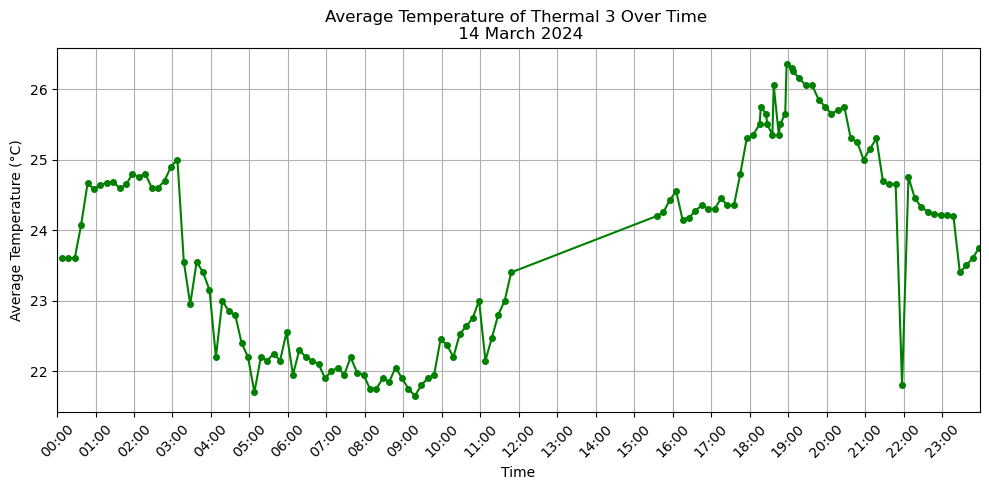

In [7]:
data = {
    'Datetime': [result[0] for result in filtered_results],
    'Hottest': [float(temp) if temp != 'Invalid' else None for temp in (result[1] for result in filtered_results)],
    'Coldest': [float(temp) if temp != 'Invalid' else None for temp in (result[2] for result in filtered_results)]
}
df = pd.DataFrame(data)

# Calculate the average temperature
df['Average'] = df[['Hottest', 'Coldest']].mean(axis=1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['Datetime'], df['Average'], marker='o', linestyle='-', color='g', markersize=4)  # Smaller marker size
plt.title('Average Temperature of Thermal 3 Over Time \n 14 March 2024')
plt.xlabel('Time')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)

# Set x-axis major ticks to hourly intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # every hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # format datetime to show only time

# Explicitly set x-axis limits
start_date = pd.to_datetime('2024-03-14 00:00')
end_date = pd.to_datetime('2024-03-14 23:59')
plt.gca().set_xlim(start_date, end_date)

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()

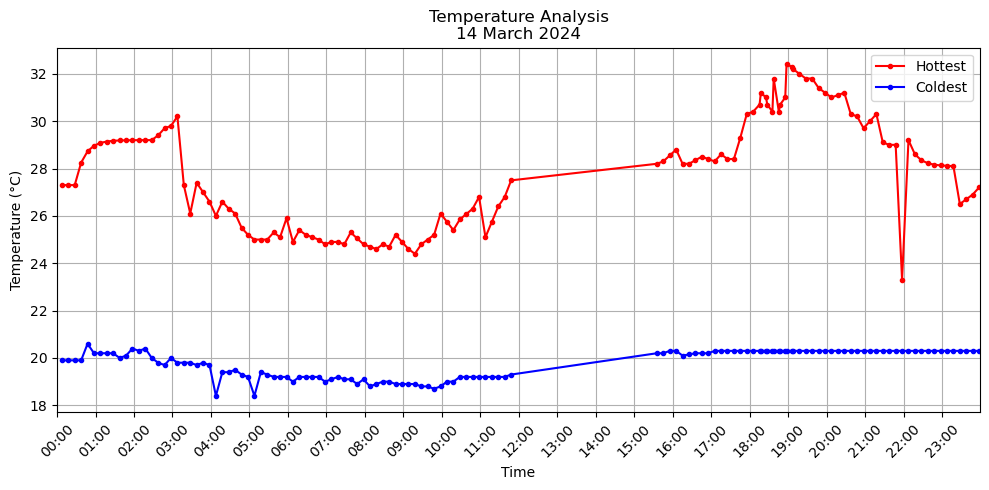

In [8]:
data = {
    'Datetime': [result[0] for result in filtered_results],
    'Hottest': [float(temp) if temp != 'Invalid' else None for temp in (result[1] for result in filtered_results)],
    'Coldest': [float(temp) if temp != 'Invalid' else None for temp in (result[2] for result in filtered_results)]
}
df = pd.DataFrame(data)

# Calculate the gap between hottest and coldest temperatures
# df['Temperature Gap'] = df['Hottest'] - df['Coldest']

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df['Datetime'], df['Hottest'], marker='o', linestyle='-', color='r', markersize=3, label='Hottest')
plt.plot(df['Datetime'], df['Coldest'], marker='o', linestyle='-', color='b', markersize=3, label='Coldest')
# plt.plot(df['Datetime'], df['Temperature Gap'], marker='x', linestyle='--', color='r', markersize=4, label='Temp Gap')

plt.title('Temperature Analysis\n14 March 2024')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Adding a legend to clarify the lines
plt.legend(loc='upper right')

# Set x-axis major ticks to hourly intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # every hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # format datetime to show only time

# Explicitly set x-axis limits
start_date = pd.to_datetime('2024-03-14 00:00')
end_date = pd.to_datetime('2024-03-14 23:59')
plt.gca().set_xlim(start_date, end_date)

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()

# Detect the heat ratio from each image

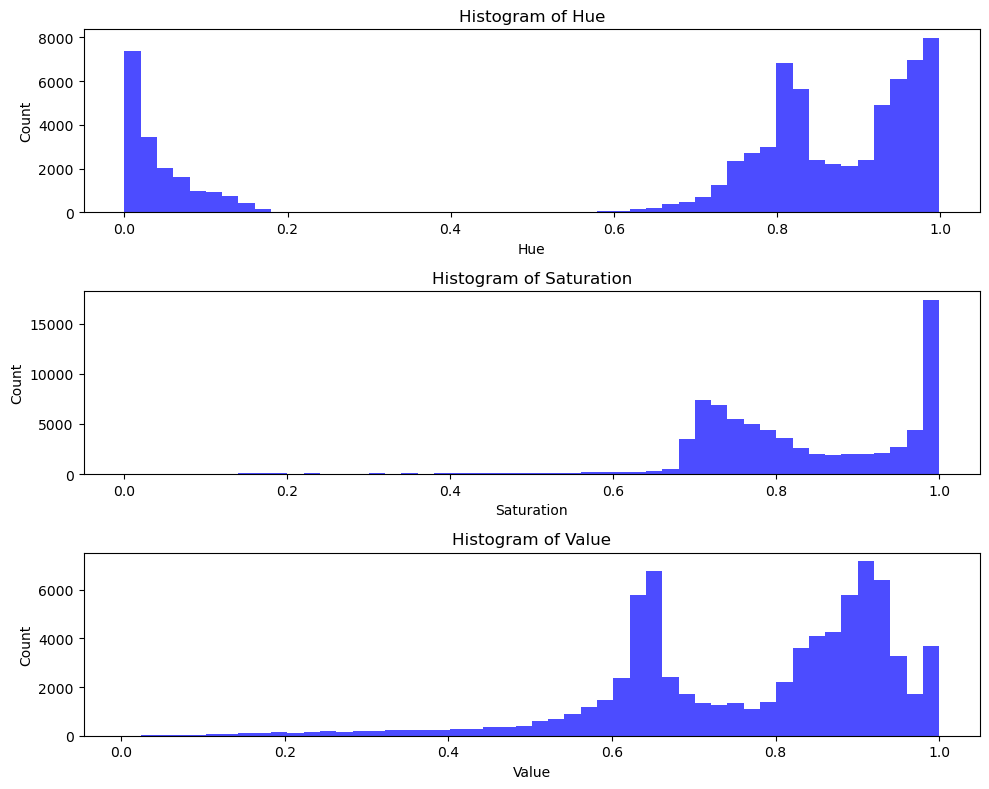

In [9]:
# Load the image and convert to HSV
img = Image.open('Thermal Placement 3/resized/photo_20240314-015739.jpg')
pixels = np.array(img)
hsv_pixels = colors.rgb_to_hsv(pixels / 255.0)  # Convert RGB to HSV

# Flatten the image for easier analysis
hsv_pixels_flat = hsv_pixels.reshape(-1, 3)

# Plot histograms for Hue, Saturation, and Value
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
titles = ['Hue', 'Saturation', 'Value']
for i, ax in enumerate(axs):
    ax.hist(hsv_pixels_flat[:, i], bins=50, color='blue', alpha=0.7)
    ax.set_title(f'Histogram of {titles[i]}')
    ax.set_xlabel(titles[i])
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# Verify the color range

In [10]:
# Load the image
img = Image.open('Thermal Placement 3/resized/photo_20240314-164517.jpg')
pixels = np.array(img)

# Function to categorize pixels
def categorize_pixel(hsv_pixel):
    hue, sat, val = hsv_pixel
    # Assuming dark colors for low temperatures
    if val < 0.2:
        return 'low'
    # Assuming red colors for highest temperatures
    elif hue < 0.1 and sat > 0.5 and val > 0.5:
        return 'high'
    # Define new ranges for 'below_mid' and 'above_mid' based on your specific needs
    # Below assumes hue ranges to distinguish between below_mid and above_mid
    elif hue < 0.3:  # Adjust the hue value to fit your data
        return 'below_mid'
    elif hue < 0.6:  # Adjust the hue value to fit your data
        return 'above_mid'
    else:
        return 'medium'

# Convert RGB to HSV for easier color segmentation
hsv_pixels = rgb_to_hsv(pixels / 255.0)  # Normalize the RGB values

# Categorize each pixel
categories = np.array([[categorize_pixel(pixel) for pixel in row] for row in hsv_pixels])

# Create an overlay image for visualizing the categorization
overlay_img = Image.new("RGB", img.size, (255, 255, 255, 0))
draw = ImageDraw.Draw(overlay_img)

# Draw rectangles based on category
for y, row in enumerate(categories):
    for x, category in enumerate(row):
        color = (255, 255, 255, 0)  # Default to transparent
        if category == 'low':
            color = (0, 0, 255, 255)  # Blue for low
        elif category == 'below_mid':
            color = (0, 255, 0, 255)  # Green for below mid
        elif category == 'medium':
            color = (255, 255, 0, 255)  # Yellow for medium
        elif category == 'above_mid':
            color = (255, 165, 0, 255)  # Orange for above mid
        elif category == 'high':
            color = (255, 0, 0, 255)  # Red for high
        draw.rectangle([x, y, x+1, y+1], fill=color)
        
# Combine the original image with the overlay
combined = Image.blend(img, overlay_img, alpha=0.5)

# Display the image
combined.show()

# Visualize heat ratio timeline

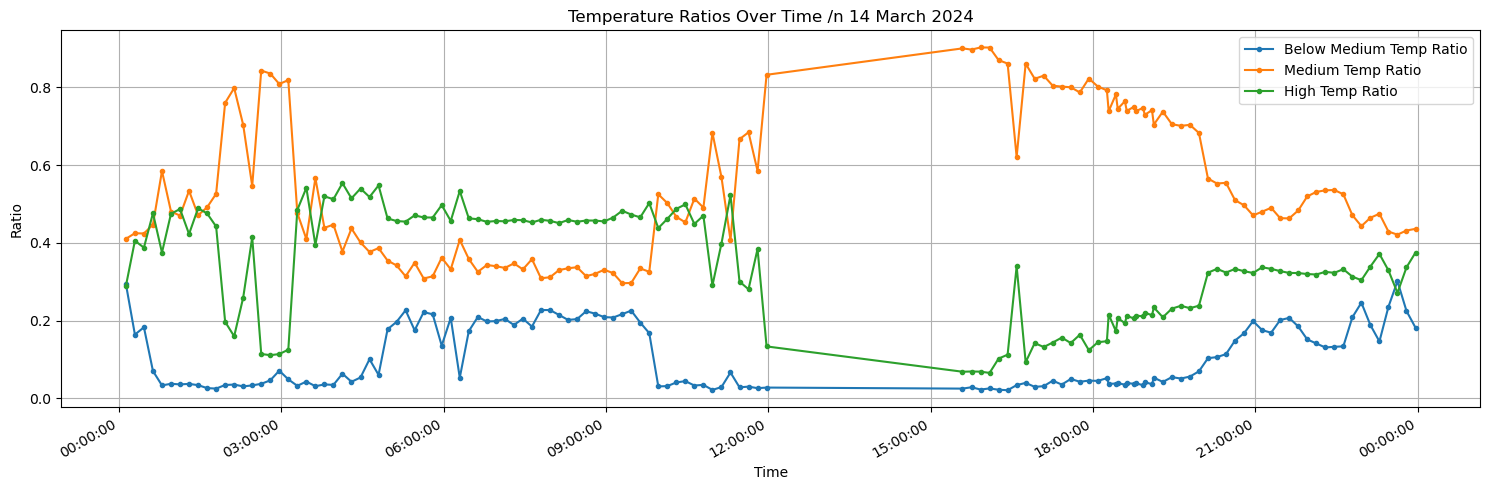

In [11]:
# Your image directory and sorting
image_directory = 'Thermal Placement 3/resized/'
image_files = sorted(os.listdir(image_directory))

# Storage for ratios
ratios = {'timestamp': [], 'low_ratio': [], 'below_mid_ratio': [], 'medium_ratio': [], 'above_mid_ratio': [], 'high_ratio': []}

# Process each image
for image_file in image_files:
    # Extract timestamp from filename (assuming format 'photo_YYYYMMDD-HHMMSS.jpg')
    timestamp = datetime.strptime(image_file, 'photo_%Y%m%d-%H%M%S.jpg')

    # Load the image
    img = Image.open(os.path.join(image_directory, image_file))
    pixels = np.array(img)

    # Convert RGB to HSV (your categorize_pixel function will be used here)
    hsv_pixels = rgb_to_hsv(pixels / 255.0)

    # Categorize each pixel (make sure your categorize_pixel function is correctly defined)
    categories = np.array([[categorize_pixel(pixel) for pixel in row] for row in hsv_pixels])

    # Flatten the categories array to count occurrences
    flat_categories = categories.flatten()

    # Count the occurrences of each category
    low_count = np.sum(flat_categories == 'low')
    below_mid_count = np.sum(flat_categories == 'below_mid')
    above_mid_count = np.sum(flat_categories == 'above_mid')
    medium_count = np.sum(flat_categories == 'medium')
    high_count = np.sum(flat_categories == 'high')
    total_pixels = flat_categories.size

    # Append the ratios and timestamp to the storage dictionary
    ratios['timestamp'].append(timestamp)
    ratios['low_ratio'].append(low_count / total_pixels)
    ratios['below_mid_ratio'].append(below_mid_count / total_pixels)
    ratios['above_mid_ratio'].append(above_mid_count / total_pixels)
    ratios['medium_ratio'].append(medium_count / total_pixels)
    ratios['high_ratio'].append(high_count / total_pixels)

# Create a DataFrame from the ratios dictionary
df = pd.DataFrame(ratios)

# Plotting the ratios over time
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['below_mid_ratio'], '-o', label='Below Medium Temp Ratio', markersize=3)
plt.plot(df['timestamp'], df['medium_ratio'], '-o', label='Medium Temp Ratio', markersize=3)
plt.plot(df['timestamp'], df['high_ratio'], '-o', label='High Temp Ratio', markersize=3)

# Formatting the plot
plt.title('Temperature Ratios Over Time /n 14 March 2024')
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True)

# Configure the x-axis to show all frame timestamps and rotate date labels for better readability
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Show the plot
plt.tight_layout()
plt.show()

# Hight Temperature vs Different Ratio

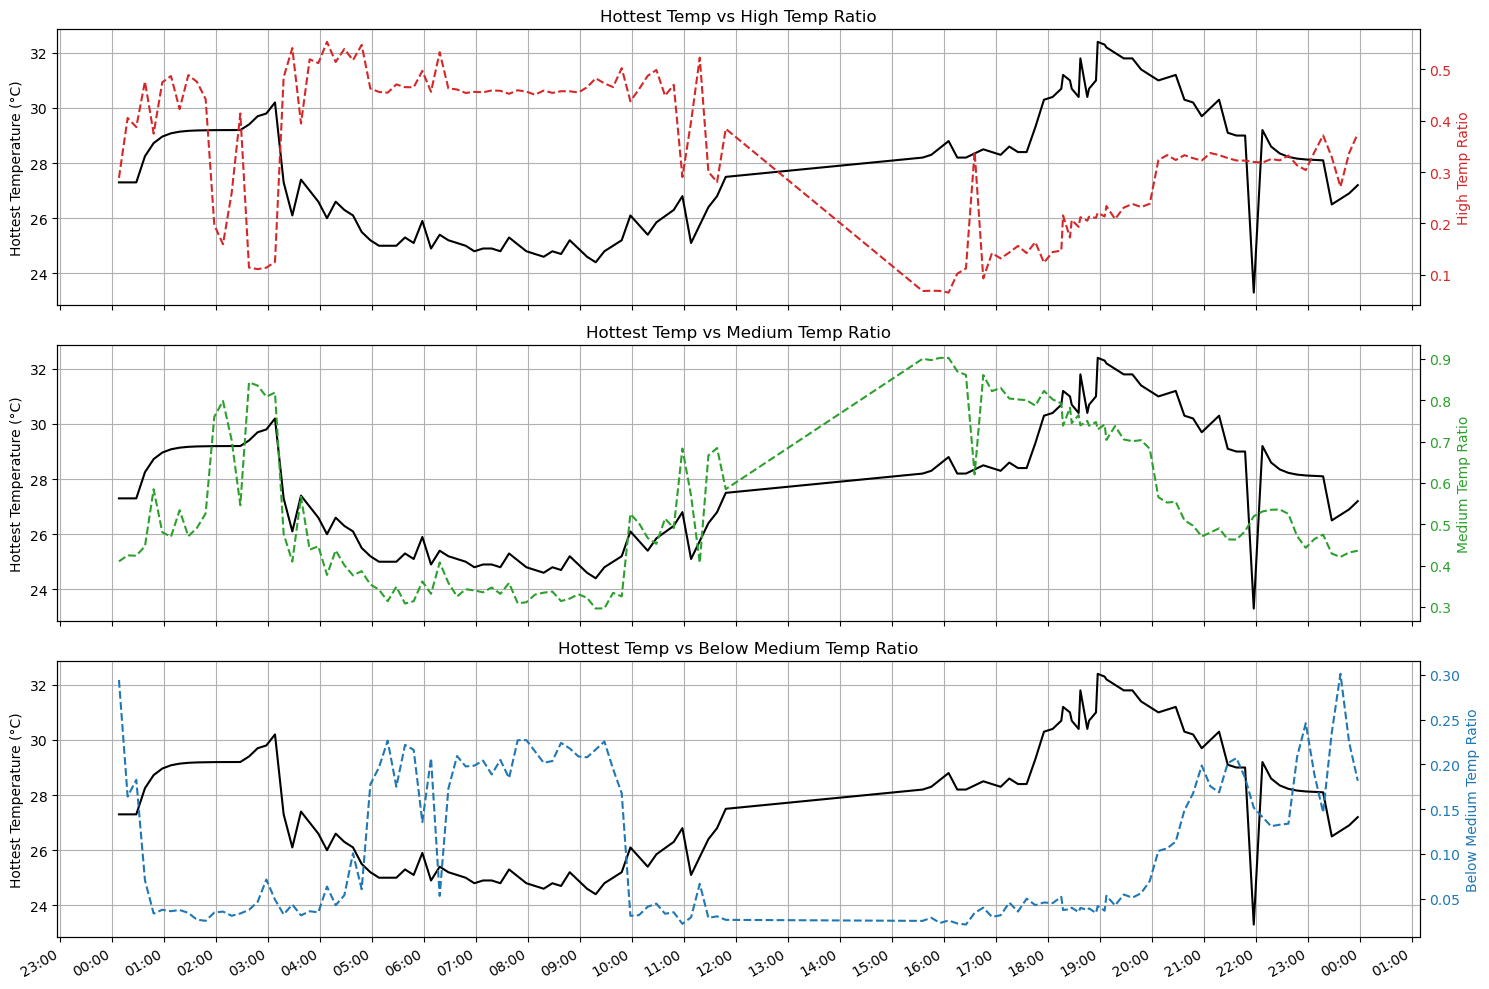

In [12]:
# Prepare the temperature data DataFrame
data = {
    'Datetime': [result[0] for result in filtered_results],
    'Hottest': [float(temp) if temp != 'Invalid' else None for temp in (result[1] for result in filtered_results)],
    'Coldest': [float(temp) if temp != 'Invalid' else None for temp in (result[2] for result in filtered_results)]
}
df = pd.DataFrame(data)

# Image directory and sorting
image_directory = 'Thermal Placement 3/resized/'
image_files = sorted(os.listdir(image_directory))

# Filter out files that do not match the expected format
image_files = [file for file in image_files if re.match(r'photo_\d{8}-\d{6}\.jpg', file)]

# Storage for ratios
ratios = {'timestamp': [], 'low_ratio': [], 'below_mid_ratio': [], 'medium_ratio': [], 'above_mid_ratio': [], 'high_ratio': []}

# Process each image
for image_file in image_files:
    # Extract timestamp from filename (assuming format 'photo_YYYYMMDD-HHMMSS.jpg')
    try:
        timestamp = datetime.strptime(image_file, 'photo_%Y%m%d-%H%M%S.jpg')
    except ValueError:
        continue  # Skip files that do not match the expected date format

    # Load the image
    img = Image.open(os.path.join(image_directory, image_file))
    pixels = np.array(img)

    # Assuming categorize_pixel and rgb_to_hsv functions are defined
    # Convert RGB to HSV and categorize pixels
    hsv_pixels = rgb_to_hsv(pixels / 255.0)
    categories = np.array([[categorize_pixel(pixel) for pixel in row] for row in hsv_pixels])
    flat_categories = categories.flatten()

    # Count the occurrences of each category
    total_pixels = flat_categories.size
    for category in ['low', 'below_mid', 'medium', 'above_mid', 'high']:
        count = np.sum(flat_categories == category)
        ratios[f"{category}_ratio"].append(count / total_pixels)
    ratios['timestamp'].append(timestamp)

# Create a DataFrame from the image analysis ratios
df_images = pd.DataFrame(ratios)

# Convert timestamps to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
df_images['timestamp'] = pd.to_datetime(df_images['timestamp'])

# Merging data on timestamps
combined_df = pd.merge_asof(df.sort_values('Datetime'), df_images.sort_values('timestamp'), left_on='Datetime', right_on='timestamp', direction='nearest')

# Plotting multiple comparisons
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Titles for each subplot
titles = ['Hottest Temp vs High Temp Ratio', 'Hottest Temp vs Medium Temp Ratio', 'Hottest Temp vs Below Medium Temp Ratio']
ratios = ['high_ratio', 'medium_ratio', 'below_mid_ratio']
colors = ['tab:red', 'tab:green', 'tab:blue']

for i in range(3):
    ax1 = axs[i]
    ax2 = ax1.twinx()

    # Plot hottest temperature trend on ax1
    ax1.plot(combined_df['Datetime'], combined_df['Hottest'], 'k-', label='Hottest Temp')
    ax1.set_ylabel('Hottest Temperature (°C)', color='k')
    ax1.tick_params(axis='y', labelcolor='k')

    # Plot temperature ratio on ax2, with color and linestyle specified separately
    ax2.plot(combined_df['timestamp'], combined_df[ratios[i]], color=colors[i], linestyle='--', label=titles[i].split(' vs ')[1])
    ax2.set_ylabel(titles[i].split(' vs ')[1], color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])

    # Set titles and grid
    ax1.set_title(titles[i])
    ax1.grid(True)

# Configure the x-axis to show hourly timestamps and format them to show only time
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Hourly ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format to show hour and minute

# Rotate date labels for better readability and adjust layout
plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()